# Goal: Forecast Pollution Level in Beijing

In [1]:
# Loading Data
import pandas as pd

pollution_filepath = 'datasets/master/Beijing PM2.5/PRSA_data_2010.1.1-2014.12.31.csv'
pollution = pd.read_csv(pollution_filepath, index_col='No', parse_dates=[['year', 'month', 'day']])
pollution = pollution.rename(columns={'year_month_day':'date'})
pollution.head()

,date,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,
1,2010-01-01,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010-01-01,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010-01-01,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010-01-01,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010-01-01,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [2]:
# Train test split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(pollution, test_size=0.1, random_state=42)

## Exploratory Data Analysis

In [3]:
train_set.head()

,date,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,
6574,2010-10-01,21,243.0,16,21.0,1015.0,SE,3.58,0,0
11901,2011-05-11,20,44.0,-10,23.0,1007.0,NW,77.78,0,0
1073,2010-02-14,16,15.0,-24,-2.0,1032.0,NE,17.88,0,0
21523,2012-06-15,18,NaN,11,27.0,1005.0,NW,4.92,0,0
29446,2013-05-11,21,38.0,-4,21.0,996.0,NE,1.79,0,0


In [4]:
train_set.shape

(39441, 10)

In [5]:
train_set.describe()

,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,39441.000000,37587.000000,39441.000000,39441.000000,39441.000000,39441.000000,39441.000000,39441.000000
mean,11.519257,98.569665,1.827946,12.457570,1016.456758,23.817751,0.052762,0.193327
std,6.920810,92.096829,14.446704,12.210063,10.266642,49.913075,0.759777,1.401778
min,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,6.000000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,12.000000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,18.000000,137.000000,15.000000,23.000000,1025.000000,21.900000,0.000000,0.000000
max,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [6]:
# Dropping rows w/ missing pm2.5
train_set_cleaned = train_set.dropna(axis=0)
train_set_cleaned.shape

(37587, 10)

In [7]:
# Datatypes of Columns
train_set_cleaned.dtypes

date     datetime64[ns]
hour              int64
pm2.5           float64
DEWP              int64
TEMP            float64
PRES            float64
cbwd             object
Iws             float64
Is                int64
Ir                int64
dtype: object

<AxesSubplot:title={'center':'Beijing PM2.5 Levels'}, xlabel='No'>

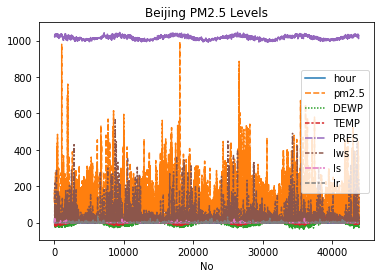

In [8]:
# Visualizing data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.title('Beijing PM2.5 Levels')
sns.lineplot(data=train_set_cleaned)

<AxesSubplot:xlabel='date', ylabel='pm2.5'>

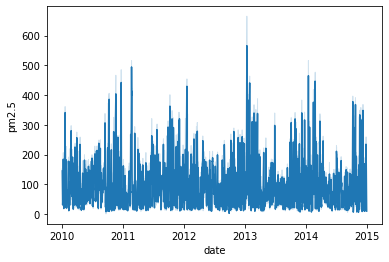

In [9]:
# PM2.5 over the years
date = train_set['date']
pm_levels = train_set['pm2.5']

sns.lineplot(x=date, y=pm_levels)

<AxesSubplot:>

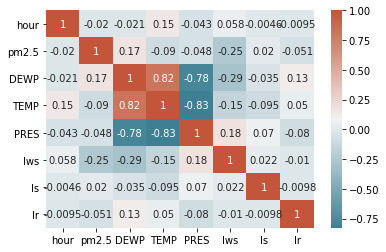

In [10]:
# Correlation Matrix
corr_mx = train_set_cleaned.corr()

sns.heatmap(corr_mx,
            xticklabels=corr_mx.columns,
           yticklabels=corr_mx.columns,
           annot=True,
           cmap=sns.diverging_palette(220, 20, as_cmap=True))

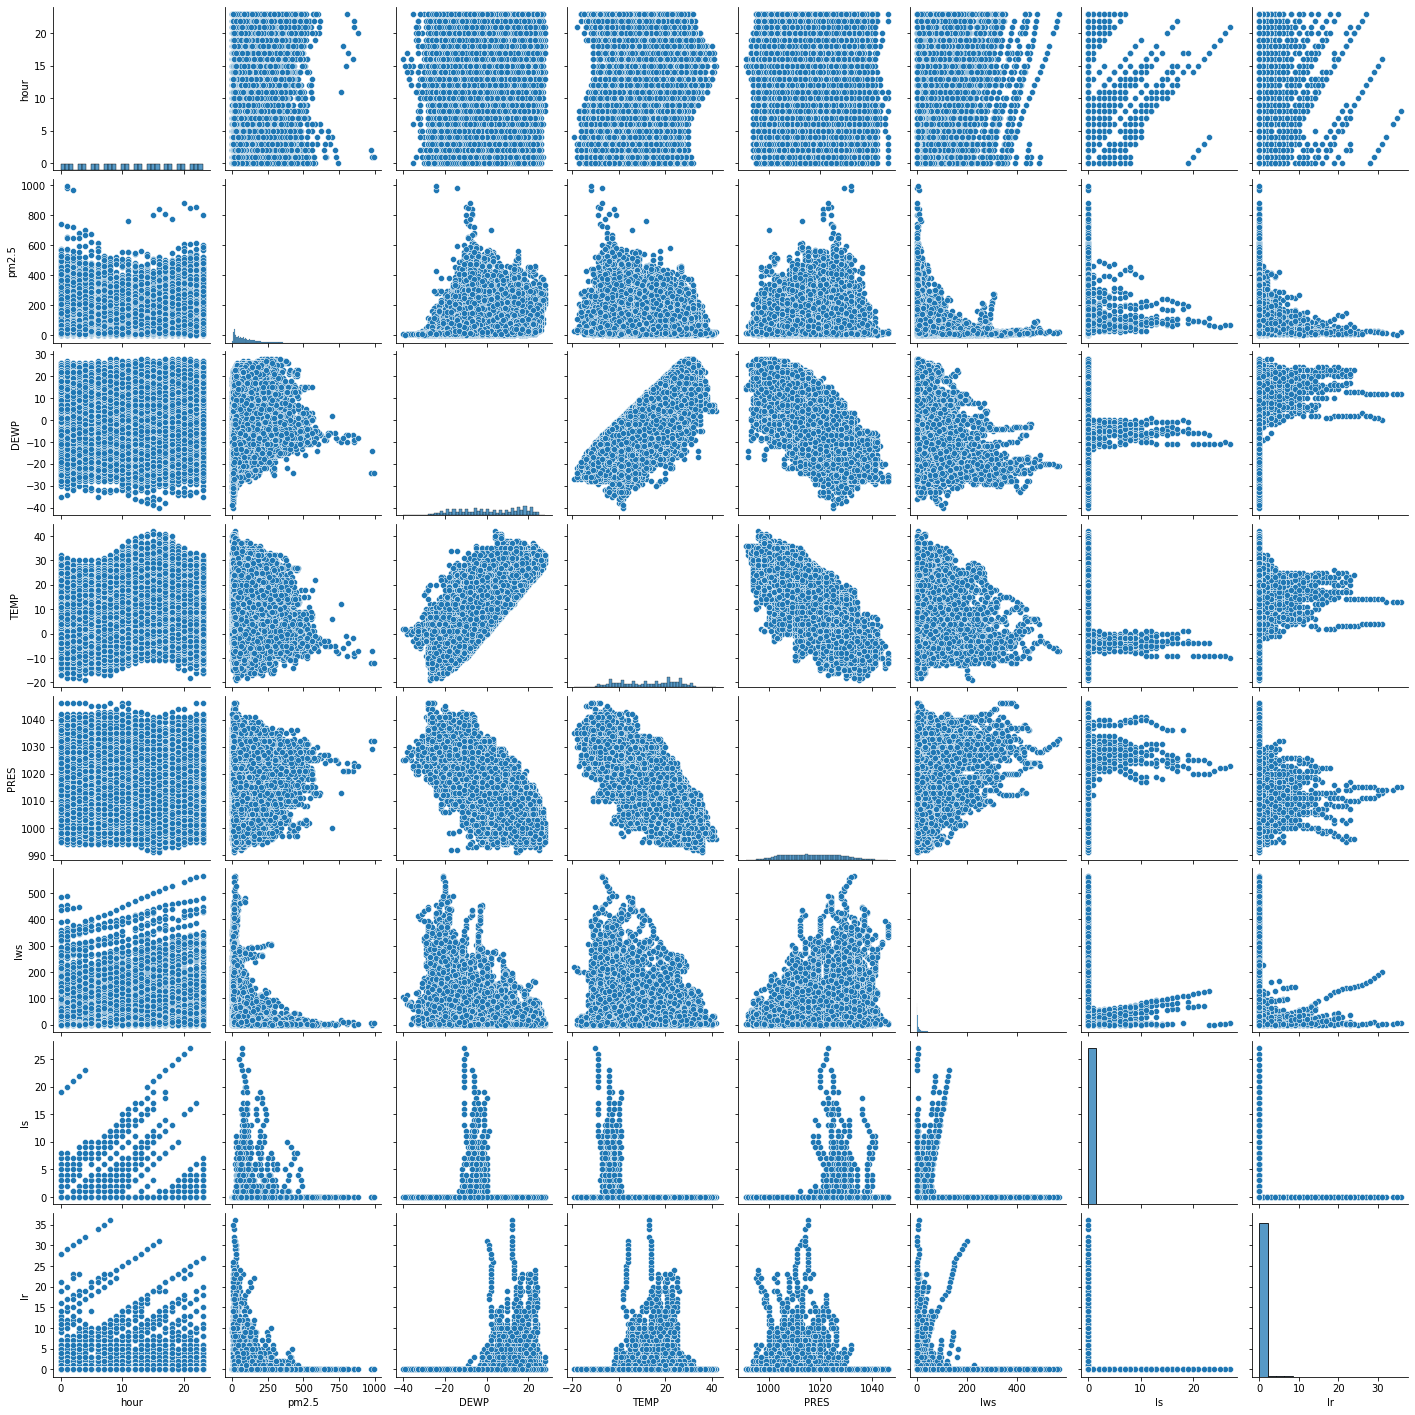

In [11]:
# Pairplot
sns.pairplot(train_set_cleaned)

## Cleaning Data

In [12]:
# ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

X_train = train_set_cleaned.drop('pm2.5', axis=1)
y_train = train_set_cleaned['pm2.5'].copy()

categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

col_trans = ColumnTransformer(transformers=[
    ('categorical', OneHotEncoder(), categorical_features),
    ('numerical', StandardScaler(), numerical_features),
])

## Training Models

In [13]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

lin_reg = LinearRegression()
forest_reg = RandomForestRegressor()
svr = SVR()

## Evaluating Models

In [14]:
# Setting up Evaluate function
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def evaluate_model(model):
    pipeline = Pipeline(steps=[
    ('prep', col_trans),
    ('model', model),])
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
    scores = np.absolute(scores)
    print('MAE for %s: %.3f (%.3f)' % (model, np.mean(scores), np.std(scores)))

In [15]:
# Evaluating Linear Regression Model
evaluate_model(lin_reg)

MAE for LinearRegression(): 56.973 (0.338)


In [16]:
# Evaluating Random Forest
evaluate_model(forest_reg)

MAE for RandomForestRegressor(): 43.681 (0.384)


In [17]:
# Evaluating SVR
evaluate_model(svr)

MAE for SVR(): 50.363 (0.451)


## Predicting on Test Set

In [18]:
# Creating Test Sets
test_set_cleaned = train_set.dropna(axis=0)
X_test = test_set_cleaned.drop('pm2.5', axis=1)
y_test = test_set_cleaned['pm2.5'].copy()

In [19]:
# Preparing test model function
from sklearn.metrics import mean_squared_error

def test_model(model):
    X_train_prepared = col_trans.fit_transform(X_train)
    X_test_prepared = col_trans.fit_transform(X_test)
    model.fit(X_train_prepared, y_train)
    preds = model.predict(X_test_prepared)
    mse = mean_squared_error(preds, y_test)
    rmse = np.sqrt(mse)
    print('RMSE for %s: %.3f' % (model, rmse))

In [20]:
# Testing models
test_model(lin_reg)
test_model(forest_reg)
test_model(svr)

RMSE for LinearRegression(): 78.742
RMSE for RandomForestRegressor(): 23.830
RMSE for SVR(): 78.405


## Deep Learning

In [21]:
# Column Transformer
X_train_cleaned = col_trans.fit_transform(X_train)
X_train_cleaned = pd.DataFrame(X_train_cleaned)
X_train_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,1.0,0.0,1.369738,0.986032,0.705319,-0.141398,-0.408078,-0.071146,-0.137453
1,0.0,1.0,0.0,0.0,1.225292,-0.813859,0.869448,-0.918124,1.090422,-0.071146,-0.137453
2,1.0,0.0,0.0,0.0,0.647508,-1.783031,-1.182168,1.509143,-0.119283,-0.071146,-0.137453
3,1.0,0.0,0.0,0.0,1.369738,-0.398500,0.705319,-1.986122,-0.444227,-0.071146,-0.137453
4,0.0,1.0,0.0,0.0,0.936400,-1.298445,-1.264232,1.314962,-0.056072,-0.071146,-0.137453


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Random Seed
tf.random.set_seed(42)

# Create Model
input_shape = [X_train_cleaned.shape[1]]
pollution_model = keras.Sequential([
    layers.Dense(1, activation='relu', input_shape=input_shape),
    layers.Dense(1)
])

# Compile Model
pollution_model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae'],
)

# Fit model
history = pollution_model.fit(X_train_cleaned, y_train, epochs=20)

Epoch 1/20
1175/1175 [==============================] - 1s 441us/step - loss: 96.6215 - mae: 96.6215
Epoch 2/20
1175/1175 [==============================] - 0s 415us/step - loss: 86.3924 - mae: 86.3924
Epoch 3/20
1175/1175 [==============================] - 0s 413us/step - loss: 73.8234 - mae: 73.8234
Epoch 4/20
1175/1175 [==============================] - 0s 420us/step - loss: 64.6892 - mae: 64.6892
Epoch 5/20
1175/1175 [==============================] - 0s 419us/step - loss: 60.2447 - mae: 60.2447
Epoch 6/20
1175/1175 [==============================] - 0s 424us/step - loss: 58.0429 - mae: 58.0429
Epoch 7/20
1175/1175 [==============================] - 0s 418us/step - loss: 57.6557 - mae: 57.6557
Epoch 8/20
1175/1175 [==============================] - 1s 436us/step - loss: 57.1047 - mae: 57.1047
Epoch 9/20
1175/1175 [==============================] - 1s 426us/step - loss: 56.1349 - mae: 56.1349
Epoch 10/20
1175/1175 [==============================] - 0s 419us/step - loss: 55.4030 - ma

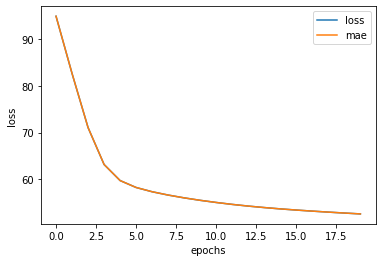

In [24]:
# Plotting Loss Curve
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [25]:
# Plot prediction function
test_set_cleaned = test_set.dropna(axis=0)
X_test = test_set_cleaned.drop('pm2.5', axis=1)
y_test = test_set_cleaned['pm2.5'].copy()
X_test_cleaned = pd.DataFrame(col_trans.fit_transform(X_test))

y_preds_1 = pollution_model.predict(X_test_cleaned)

from sklearn.metrics import mean_squared_error
y_preds_1.shape, y_test.shape
mse = mean_squared_error(y_preds_1.squeeze(), y_test)
print(mse)

6698.023570047382
